<a href="https://colab.research.google.com/github/In-Jung-Jeong/project/blob/main/Section2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1) 데이터 선정 이유 및 문제 정의
개봉영화의 정보를 가지고 그 영화의 매출액을 예측하는 모델을 만들고자합니다.
  
KOBIS 영화관입장권통합전산망의 박스오피스에서 2000년부터 2020년 까지 한국에서 
개봉한 모든 영화 데이터를 가져와서 사용하겠습니다.  
매출액을 예측하고자 하기때문에 회귀문제로 접근하겠습니다.

In [ ]:
!pip install category_encoders
!pip install eli5
!pip install shap
!pip install pdpbox

In [ ]:
from google.colab import files
import pandas as pd
import io

uploaded = files.upload()

Saving 영화데이터(2000~2020).xls.xlsx to 영화데이터(2000~2020).xls.xlsx


In [ ]:
df = pd.read_excel(io.BytesIO(uploaded['영화데이터(2000~2020).xls.xlsx']))   # 데이터는 KOBIS 영화관입장권통합전산망의 박스오피스에서 내려받은 데이터셋을 사용합니다.
df.head()

,순번,영화명,감독,제작사,수입사,배급사,개봉일,영화유형,영화형태,국적,전국스크린수,전국매출액,전국관객수,장르,등급,영화구분
0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,명량,김한민,(주)빅스톤픽쳐스,NaN,(주)씨제이이엔엠,2014-07-30,개봉영화,장편,한국,1587.0,1.357484e+11,17613682.0,사극,15세이상관람가,일반영화
2,2.0,극한직업,이병헌,"(주)어바웃필름,영화사 해그림 주식회사,(주)씨제이이엔엠",NaN,(주)씨제이이엔엠,2019-01-23,개봉영화,장편,한국,1978.0,1.396480e+11,16264944.0,코미디,15세이상관람가,일반영화
3,3.0,신과함께-죄와 벌,김용화,"리얼라이즈픽쳐스(주),(주)덱스터스튜디오",NaN,롯데쇼핑㈜롯데엔터테인먼트,2017-12-20,개봉영화,장편,한국,1912.0,1.156987e+11,14410754.0,판타지,12세이상관람가,일반영화
4,4.0,국제시장,윤제균,"(주)제이케이필름,(주)씨제이이엔엠",NaN,(주)씨제이이엔엠,2014-12-17,개봉영화,장편,한국,966.0,1.108280e+11,14245998.0,드라마,12세이상관람가,일반영화


### 2) 데이터를 이용한 가설 및 평가지표, 베이스라인 선택

1. 해당 특성을 target으로 지정한 이유를 설명하세요.  
 개봉한 영화의 정보를 가지고 그 영화의 매출액을 예측하고자 하므로 전국매출액 특성을 target으로 지정하겠습니다.

2. 해당 베이스라인 모델과 평가지표를 선택한 이유를 설명하세요.  
  회귀 문제로 접근할 것이기 때문에 베이스라인 모델은 타겟특성의 평균값으로 예측하는 모델을 사용하도록 하고, 평가지표는 r2 score를 사용하도록 하겠습니다.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

target = '전국매출액'
baseline = [df[target].mean()] * len(df[target])
baseline_r2score = r2_score(df[target].fillna(0), baseline)
baseline_rmse = np.sqrt(mean_squared_error(df[target].fillna(0), baseline))
print('r2_score :', baseline_r2score)
print('rmse :', baseline_rmse)
print('타겟(전국매출액) 평균값 :', df[target].mean())   

r2_score : -1.6840863670264383e-06
rmse : 6113123664.053403
타겟(전국매출액) 평균값 : 1094257034.0102713


In [ ]:
df.sort_values('전국매출액', ascending=False)['전국매출액'].head(1)   # baseline r2_score : -1.68, rmse : 약 61억, 
                                                                      # 전국매출액 평균 : 약 11억, 최고 전국매출액 : 약 1400억  - 흥행을 한 영화와 그렇지 못한 영화의 매출액 차이가 심한걸 알 수 있다.

2    1.396480e+11
Name: 전국매출액, dtype: float64

### 3) EDA와 데이터 전처리
1. Data Leakage가 있었나요? 없었다면 어떻게 방지했나요?  
Data Leakage는 없었습니다. Data Leakage를 방지하기 위해 전국매출액 특성을 target 특성으로 지정해서 분리해 주었습니다.

2. 정인중님이 만들고자 하는 모델은 언제 유용한가요? 어떤 한계를 가지고 있나요?  
- 모델의 유용성 : 포털사이트에서 궁금한 영화의 제목을 검색해보면 관객수, 감독, 장르, 배급사 등 영화에 대한 기본적인 정보들이 나오지만 그 영화의 매출액은 나오지 않습니다. 이 모델을 통해서 전문적인 데이터 베이스를 찾아보지 않아도 해당 영화의 대략적인 매출액을 예상해 볼 수 있고 그 결과값을 통해 해당 영화를 볼지, 아니면 단지 그 영화의 매출액이 얼마였는지, 또는 상업적으로 얼마나 성공적인 영화였는지, 그 외 여러가지 목적에 따른 판단을 하는 지표로 사용될 수 있습니다.

- 한계점 : 모델을 통해 얻는 값이 실제값과 근사하더라도 어디까지나 예측값이므로 해당 영화의 정확한 매출액이 아니라는점, 영화의 특이도에 따라 오차값이 클 수도 있지만 실제 상황에서 해당 영화의 정확한 매출액을 찾아보지 않는이상 예측값과 실제값이 얼마나 차이가 날지 모른다는점 등이 있다. 따라서 해당 모델을 통해 얻는 예측값은 어디까지나 참고용 으로만 사용하도록 한다.

In [ ]:
# 첫번째 행은 excel파일의 columns이 두줄에 걸쳐 출력되었으므로 삭제하고, 첫번째 열은 인덱스가 겹치므로 삭제해 줍니다.
# 또한 영화명과 개봉일은 예측을 할때 연관성이 낮은 부분이라 판단하고 삭제하겠습니다.
df = df.drop(index=0)
df = df.drop(columns=['순번', '영화명', '개봉일'], axis=1)
df.head()

,감독,제작사,수입사,배급사,영화유형,영화형태,국적,전국스크린수,전국매출액,전국관객수,장르,등급,영화구분
1,김한민,(주)빅스톤픽쳐스,NaN,(주)씨제이이엔엠,개봉영화,장편,한국,1587.0,1.357484e+11,17613682.0,사극,15세이상관람가,일반영화
2,이병헌,"(주)어바웃필름,영화사 해그림 주식회사,(주)씨제이이엔엠",NaN,(주)씨제이이엔엠,개봉영화,장편,한국,1978.0,1.396480e+11,16264944.0,코미디,15세이상관람가,일반영화
3,김용화,"리얼라이즈픽쳐스(주),(주)덱스터스튜디오",NaN,롯데쇼핑㈜롯데엔터테인먼트,개봉영화,장편,한국,1912.0,1.156987e+11,14410754.0,판타지,12세이상관람가,일반영화
4,윤제균,"(주)제이케이필름,(주)씨제이이엔엠",NaN,(주)씨제이이엔엠,개봉영화,장편,한국,966.0,1.108280e+11,14245998.0,드라마,12세이상관람가,일반영화
5,"안소니 루소,조 루소",NaN,월트디즈니컴퍼니코리아 유한책임회사,월트디즈니컴퍼니코리아 유한책임회사,개봉영화,장편,미국,2835.0,1.221827e+11,13934592.0,액션,12세이상관람가,일반영화


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16965 entries, 1 to 16965
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   감독      16262 non-null  object 
 1   제작사     5983 non-null   object 
 2   수입사     11549 non-null  object 
 3   배급사     16408 non-null  object 
 4   영화유형    16965 non-null  object 
 5   영화형태    16964 non-null  object 
 6   국적      16964 non-null  object 
 7   전국스크린수  16965 non-null  float64
 8   전국매출액   16843 non-null  float64
 9   전국관객수   16965 non-null  float64
 10  장르      16885 non-null  object 
 11  등급      16949 non-null  object 
 12  영화구분    16965 non-null  object 
dtypes: float64(3), object(10)
memory usage: 1.8+ MB


In [ ]:
# 제작사가 있으면 수입사가 없고, 수입사가 있으면 제작사가 없기에 두 특성에서 결측값은 na라는 str로 지정해주고 나중에 인코딩하도록 한다.
df[['제작사', '수입사']] = df[['제작사', '수입사']].fillna('na')
df.shape

(16965, 13)

In [ ]:
df.isnull().sum()

감독        703
제작사         0
수입사         0
배급사       557
영화유형        0
영화형태        1
국적          1
전국스크린수      0
전국매출액     122
전국관객수       0
장르         80
등급         16
영화구분        0
dtype: int64

In [ ]:
df = df.dropna()   # 남은 전체 데이터에서 결측치 비율이 미미하므로 결측치가 있는 행은 삭제한다.
df.shape

(15549, 13)

In [ ]:
df.head()

,감독,제작사,수입사,배급사,영화유형,영화형태,국적,전국스크린수,전국매출액,전국관객수,장르,등급,영화구분
1,김한민,(주)빅스톤픽쳐스,na,(주)씨제이이엔엠,개봉영화,장편,한국,1587.0,1.357484e+11,17613682.0,사극,15세이상관람가,일반영화
2,이병헌,"(주)어바웃필름,영화사 해그림 주식회사,(주)씨제이이엔엠",na,(주)씨제이이엔엠,개봉영화,장편,한국,1978.0,1.396480e+11,16264944.0,코미디,15세이상관람가,일반영화
3,김용화,"리얼라이즈픽쳐스(주),(주)덱스터스튜디오",na,롯데쇼핑㈜롯데엔터테인먼트,개봉영화,장편,한국,1912.0,1.156987e+11,14410754.0,판타지,12세이상관람가,일반영화
4,윤제균,"(주)제이케이필름,(주)씨제이이엔엠",na,(주)씨제이이엔엠,개봉영화,장편,한국,966.0,1.108280e+11,14245998.0,드라마,12세이상관람가,일반영화
5,"안소니 루소,조 루소",na,월트디즈니컴퍼니코리아 유한책임회사,월트디즈니컴퍼니코리아 유한책임회사,개봉영화,장편,미국,2835.0,1.221827e+11,13934592.0,액션,12세이상관람가,일반영화


### 4) 머신러닝 방식 적용 및 교차검증


In [ ]:
from sklearn.model_selection import train_test_split

 #훈련, 검증, 테스트 데이터셋을 무작위로 나누어 줍니다.

target = '전국매출액'
features = df.drop(target, axis=1).columns
train, test = train_test_split(df, train_size=0.80, test_size=0.20,
                              random_state=2)
train, val = train_test_split(train, train_size=0.80, test_size=0.20,
                              random_state=2)

X_train = train[features]
X_val = val[features]
X_test = test[features]

y_train = train[target]
y_val = val[target]
y_test = test[target]

print(train.shape, val.shape, test.shape)

(9951, 13) (2488, 13) (3110, 13)


In [ ]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler


pipe = make_pipeline(
    OrdinalEncoder(),
    RobustScaler(),
    XGBRegressor(max_depth=10, n_estimators = 100, random_state=2)
)

pipe.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[13:40:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['감독', '제작사', '수입사', '배급사', '영화유형', '영화형태',
                                      '국적', '장르', '등급', '영화구분'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': '감독', 'data_type': dtype('O'),
                                          'mapping': 레이먼드 후버                1
이세일                    2
안슬기                    3
미카엘 하프스트롬              4
후지모리 카나                5
                    ... 
존 포그                5301
김조광수,여명준,조은경,홍동명    5302
니마 누리자데             5303
브루스 폰테인             5304
NaN                   -2
Length: 5305, dtyp...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              

In [ ]:
# 평가지표를 계산 후 베이스라인과 비교해보세요.

y_pred = pipe.predict(X_train)
pipe_train_r2score = r2_score(y_train, y_pred)
print(' pipe r2_score :', pipe_train_r2score, '\n', 'baseline_r2score :', baseline_r2score)

 pipe r2_score : 0.9999821589724033 
 baseline_r2score : -1.6840863670264383e-06


In [ ]:
# 어느정도 성능이 나왔다면, 교차 검증 (이하 CV)을 통해서 일반화될 가능성이 있는지 확인해봅니다.

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle = True, random_state=2)
scores = cross_val_score(pipe, X_train, y_train, cv = kfold)

# Trainingdata에 대한 성능을 나타낸다.
print('교차 검증별 정확도:',scores)
print('평균 검증 정확도:', np.mean(scores))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[13:56:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[13:56:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[13:56:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[13:56:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[13:56:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
교차 검증별 정확도: [0.9878757  0.99529359 0.99001908 0.78627396 0.98007681]
평균 검증 정확도: 0.9479078271541915


In [ ]:
# 모델 성능을 개선하기 위한 다양한 방법을 적용해보세요.

simple_pipe = make_pipeline(
    OrdinalEncoder(),
    RobustScaler(),
)
simple_pipe.fit(df)
simple_df = simple_pipe.transform(df)
simple_df = pd.DataFrame(simple_df, columns = df.columns)
pd.DataFrame(simple_df.corr().sort_values('전국매출액', ascending=False)['전국매출액'])  # df에 인코더와 스케일러를 사용해주고, 특성별 상관계수를 타겟특성에 대해 내림차순으로 정리하여 상관계수가 높은 특성을 찾아보았습니다.

,전국매출액
전국매출액,1.000000
전국관객수,0.905005
전국스크린수,0.733253
영화형태,-0.010918
국적,-0.068143
제작사,-0.094132
영화구분,-0.099690
장르,-0.113738
수입사,-0.148497
등급,-0.160739


In [ ]:
# 상관계수가 높은 특성들만을 이용해서 모델링한 후 기존모델과 비교해보도록 합니다.

cut_df = df[['전국스크린수', '전국관객수', '전국매출액']]

features = cut_df.drop(target, axis=1).columns
train, test = train_test_split(cut_df, train_size=0.80, test_size=0.20,
                              random_state=2)
train, val = train_test_split(train, train_size=0.80, test_size=0.20,
                              random_state=2)

X_train_cut = train[features]
X_val_cut = val[features]
X_test_cut = test[features]

y_train_cut = train[target]
y_val_cut = val[target]
y_test_cut = test[target]

print(train.shape, val.shape, test.shape)

cut_pipe = make_pipeline(
    OrdinalEncoder(),
    RobustScaler(),
    XGBRegressor(max_depth=10, n_estimators = 100, random_state=2)
)

cut_pipe.fit(X_train_cut, y_train_cut)

(9951, 3) (2488, 3) (3110, 3)
[15:31:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=10,
                              min_child_weight=1, missing=None,
                              n_estimators=100, n_jobs=1, nthread=None,
                              objective='reg:linear', 

In [ ]:
y_pred = cut_pipe.predict(X_train_cut)
cut_pipe_train_r2score = r2_score(y_train_cut, y_pred)
print('pipe_train_r2score :', pipe_train_r2score)
print('cut_pipe_train_r2score :', cut_pipe_train_r2score)

pipe_train_r2score : 0.9999821589724033
cut_pipe_train_r2score : 0.9999180302628881


In [ ]:
y_pred = pipe.predict(X_val)
pipe_val_r2score = r2_score(y_val, y_pred)
y_pred = cut_pipe.predict(X_val_cut)
cut_pipe_val_r2score = r2_score(y_val_cut, y_pred)
print('pipe_val_r2score :', pipe_val_r2score)
print('cut_pipe_val_r2score :', cut_pipe_val_r2score)

pipe_val_r2score : 0.9914753470503718
cut_pipe_val_r2score : 0.9918420028497051


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

dists = {
    'xgbregressor__n_estimators': randint(50, 500), 
    'xgbregressor__max_depth': [10, 15, 20, 25], 
    'xgbregressor__max_features': [1, 3, 5, 7, 9]
}
pipe_tun = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_squared_error',  
    verbose=1,
    n_jobs=-1
)
pipe_tun.fit(X_train, y_train);
print('최적 하이퍼파라미터: ', pipe_tun.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 14.8min finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[16:05:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
최적 하이퍼파라미터:  {'xgbregressor__max_depth': 10, 'xgbregressor__max_features': 9, 'xgbregressor__n_estimators': 63}


In [ ]:
y_pred = pipe_tun.predict(X_train)
print(r2_score(y_train, y_pred))
y_pred = pipe_tun.predict(X_val)
print(r2_score(y_val, y_pred))

0.9998735572413681
0.9914718847853974


In [ ]:
# 최소 2개 이상의 모델을 만들어서 validation 점수를 보고하세요.

from sklearn.linear_model import LinearRegression

Linear_pipe = make_pipeline(
    OrdinalEncoder(),
    RobustScaler(),
    LinearRegression()
)

Linear_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['감독', '제작사', '수입사', '배급사', '영화유형', '영화형태',
                                      '국적', '장르', '등급', '영화구분'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': '감독', 'data_type': dtype('O'),
                                          'mapping': 레이먼드 후버                1
이세일                    2
안슬기                    3
미카엘 하프스트롬              4
후지모리 카나                5
                    ... 
존 포그                5301
김조광수,여명준,조은경,홍동명    5302
니마 누리자데             5303
브루스 폰테인             5304
NaN                   -2
Length: 5305, dtyp...
연소자관람가,전체관람가              17
NaN                       -2
dtype: int64},
                                         {'col': '영화구분',
                                          'data_type': dtype('O'),
                                    

In [ ]:
y_pred = Linear_pipe.predict(X_train)
print('Linear_pipe 모델 train 점수 :', r2_score(y_train, y_pred))
y_pred = Linear_pipe.predict(X_val)
print('Linear_pipe 모델 val 점수 :', r2_score(y_val, y_pred))

Linear_pipe 모델 train 점수 : 0.8503337386256221
Linear_pipe 모델 val 점수 : 0.821884436265136


In [ ]:
y_pred = pipe.predict(X_val)
print('pipe 모델 validation 점수        :', r2_score(y_val, y_pred))
y_pred = Linear_pipe.predict(X_val)
print('Linear_pipe 모델 validation 점수 :', r2_score(y_val, y_pred))

pipe 모델 validation 점수        : 0.9914753470503718
Linear_pipe 모델 validation 점수 : 0.821884436265136


In [ ]:
# 최종 모델의 test 점수를 보고하세요.

y_pred = pipe.predict(X_test)
print('pipe(최종 모델) test 점수(r2 score) :', r2_score(y_test, y_pred))
print('baseline r2 score                   :', baseline_r2score)
print('pipe(최종 모델) test 점수(rmse)     :', np.sqrt(mean_squared_error(y_test, y_pred)))
print('baseline rmse                       :', baseline_rmse)       # 최종모델 r2 score : 약 0.99, baseline r2 score : 약 -1.68
print('타겟 평균값                         :', df[target].mean())   # 최종모델 rmse : 약 5억, baseline rmse : 약 61억

pipe(최종 모델) test 점수(r2 score) : 0.9938604185528389
baseline r2 score                   : -1.6840863670264383e-06
pipe(최종 모델) test 점수(rmse)     : 565694219.7401273
baseline rmse                       : 6113123664.053403
타겟 평균값                         : 1094257034.0102713


- 모델을 학습한 후에 베이스라인보다 잘 나왔나요? 그렇지 않다면 그 이유는 무엇일까요?  
베이스라인 보다 훨씬 더 좋은 점수를 보입니다.  
- 모델 성능 개선을 위해 어떤 방법을 적용했나요? 그 방법을 선택한 이유는 무엇인가요?  
특성별 상관계수를 조사하여 타겟과 높은 상관계수를 보이는 특성들의 조합으로 모델링을 해보았고, RandomizedSearchCV를 통해 더 적합한 하이퍼 파라미터가 있는지 찾아보았습니다.
- 최종 모델에 관해 설명하세요.  
인코더와 스케일러를 거친 데이터를 XGBRegressor를 통해 학습하였고 train, val, test 세개의 데이터에서 모두 99점대의 r^2 score를 보여 일반화가 된 좋은 성능의 모델이 만들어졌다고 생각합니다.

### 5) 머신러닝 모델 해석  
- PDP, SHAP을 활용하여 최종 모델을 설명합니다
- 시각화는 "설명"이 제일 중요합니다.

In [ ]:
simple_df.head()

,감독,제작사,수입사,배급사,영화유형,영화형태,국적,전국스크린수,전국매출액,전국관객수,장르,등급,영화구분
0,-0.914920,-0.004762,-0.270769,-0.835637,0.0,0.0,-0.5,49.56250,3246.793198,1144.841599,-1.000000,-1.00,0.0
1,-0.914676,-0.003571,-0.270769,-0.835637,0.0,0.0,-0.5,61.78125,3340.062510,1057.175821,-0.888889,-1.00,0.0
2,-0.914432,-0.002381,-0.270769,-0.834101,0.0,0.0,-0.5,59.71875,2767.247808,936.656484,-0.777778,-0.75,0.0
3,-0.914188,-0.001190,-0.270769,-0.835637,0.0,0.0,-0.5,30.15625,2650.752923,925.947611,-0.666667,-0.75,0.0
4,-0.913944,0.000000,-0.267692,-0.832565,0.0,0.0,0.0,88.56250,2922.331653,905.706727,-0.555556,-0.75,0.0


In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import matplotlib.pyplot as plt
from pdpbox import pdp
import shap

simple_df.columns = ['director', 'producer', 'importer', 'distributor', 'movie type', 'film format', 'nationality', 'total screens', '전국매출액', 'total audience', 'genre', 'class', 'Movie Category']
E_features = ['director', 'producer', 'importer', 'distributor', 'movie type', 'film format', 'nationality', 'total screens', 'total audience', 'genre', 'class', 'Movie Category']

train, test = train_test_split(simple_df, train_size=0.80, test_size=0.20,
                              random_state=2)
train, val = train_test_split(train, train_size=0.80, test_size=0.20,
                              random_state=2)

X_train_simple = train[E_features]
X_val_simple = val[E_features]
X_test_simple = test[E_features]

y_train_simple = train[target]
y_val_simple = val[target]
y_test_simple = test[target]

model = XGBRegressor(max_depth=10, n_estimators = 100, random_state=2)
model.fit(X_train_simple, y_train)

[17:21:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=2,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

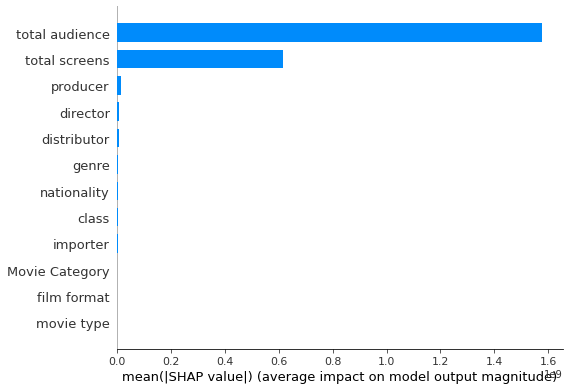

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val_simple.iloc[:300], check_additivity=False)   # 만들어진 모델이 예측을 하는데 있어서 전국관객수(total audience)와 전국스크린수(total screens) 특성이 중요한 지표로 작용하는것으로 보입니다. 
shap.summary_plot(shap_values, X_val_simple.iloc[:300], plot_type="bar")               # 두 특성이 예측값에 어떠한 영향을 미치는지 더 알아보겠습니다.

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f379a0bfc90>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f379a0934d0>})

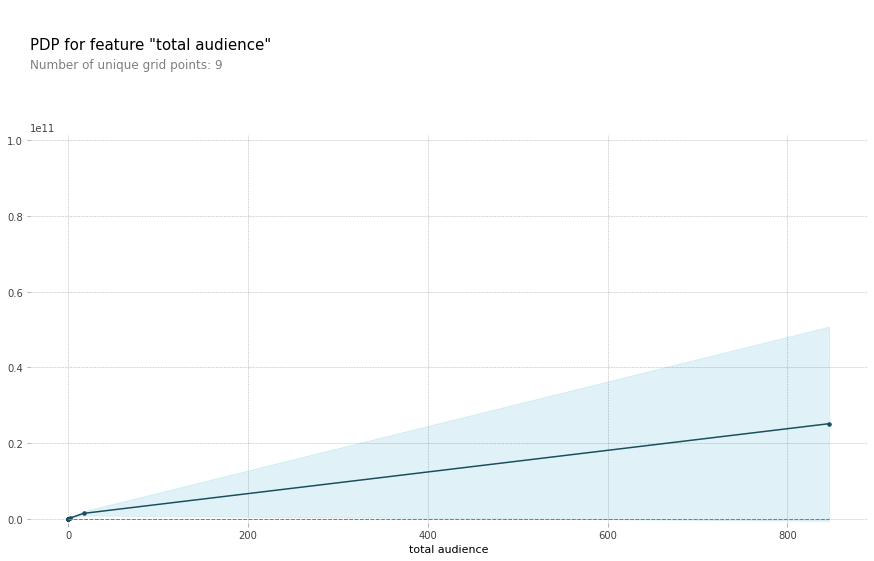

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'total audience'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_simple, 
    model_features=X_val_simple.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature)   # 전국관객수 특성값이 증가할수록 예측값 또한 증가합니다

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f379a00c210>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3799fd3a90>})

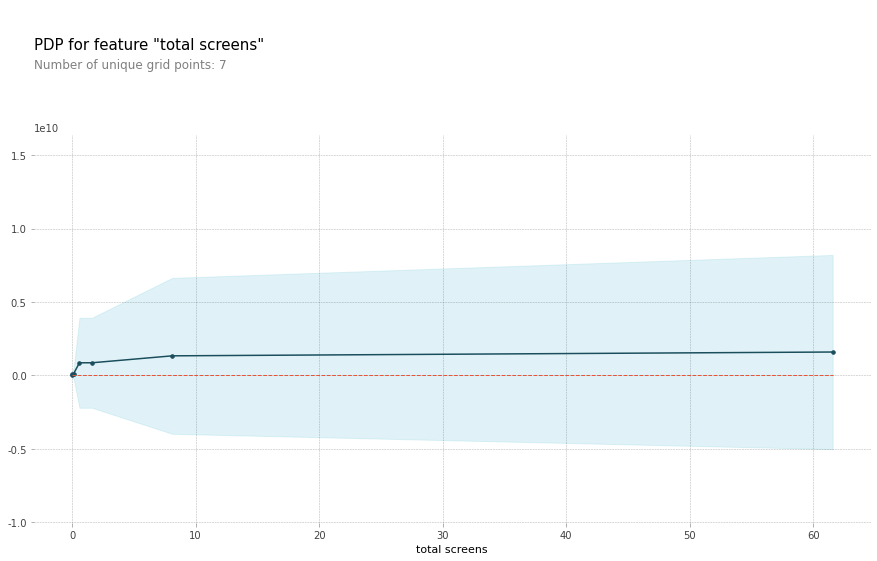

In [ ]:
feature = 'total screens'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_simple, 
    model_features=X_val_simple.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature)   # 전국스크린수 특성값이 증가할수록 예측값 또한 전체적으로 증가하는 양상을 보입니다.

- 모델이 관측치를 예측하기 위해서 어떤 특성을 활용했나요?  
전국관객수와 전국스크린수 특성을 활용한것으로 보입니다.
-  어떤 특성이 있다면 모델의 예측에 도움이 될까요? 해당 특성은 어떻게 구할 수 있을까요?  
영화의 총 상영횟수를 나타내는 특성이 있으면 모델 예측에 도움이 될 것 같습니다.  
KOBIS 영화관입장권통합전산망 데이터 베이스를 찾아보면 있을지도 모르겠습니다.